http://www.algo-fx-blog.com/lstm-fx-predict/

In [1]:
import datetime

import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
df = pd.read_csv('FX_MA_5days.csv', sep=',')
df.head()

,time,open,high,low,close,5mean,target
0,2016-11-07 07:00:00,104.101,104.630,103.779,104.476,103.6076,0
1,2016-11-08 07:00:00,104.462,105.194,104.297,105.176,103.8124,1
2,2016-11-09 07:00:00,105.178,105.890,101.193,105.658,104.2828,1
3,2016-11-10 07:00:00,105.685,106.949,104.960,106.816,105.0504,1
4,2016-11-11 07:00:00,106.796,106.934,106.032,106.683,105.7618,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 7 columns):
time      789 non-null object
open      789 non-null float64
high      789 non-null float64
low       789 non-null float64
close     789 non-null float64
5mean     789 non-null float64
target    789 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 43.3+ KB


In [4]:
del df['5mean']
del df['target']

In [5]:
split_data = '2019-05-06 06:00:00'
train, test = df[df['time'] < split_data], df[df['time'] >= split_data]
del train['time']
del test['time']

In [6]:
train.shape, test.shape

((650, 4), (139, 4))

In [7]:
window_len = 5

In [8]:
train_lstm_in = []
for i in range(len(train) - window_len):
    temp = train[i:(i + window_len)].copy()
    for col in train:
        temp.loc[:, col] = temp[col] / temp[col].iloc[0] - 1
    train_lstm_in.append(temp)
lstm_train_out = (train['close'][window_len:].values / train['close'][:-window_len].values)-1
 
test_lstm_in = []
for i in range(len(test) - window_len):
    temp = test[i:(i + window_len)].copy()
    for col in test:
        temp.loc[:, col] = temp[col] / temp[col].iloc[0] - 1
    test_lstm_in.append(temp)
lstm_test_out = (test['close'][window_len:].values / test['close'][:-window_len].values)-1

In [9]:
train_lstm_in = [np.array(train_lstm_input) for train_lstm_input in train_lstm_in]
train_lstm_in = np.array(train_lstm_in)

test_lstm_in = [np.array(test_lstm_input) for test_lstm_input in test_lstm_in]
test_lstm_in = np.array(test_lstm_in)

In [10]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
 
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
 
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
    return model

In [11]:
np.random.seed(202)
 
yen_model = build_model(train_lstm_in, output_size=1, neurons = 20)
 
yen_history = yen_model.fit(train_lstm_in, lstm_train_out, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
 - 4s - loss: 0.0066 - acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: 0.0053 - acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: 0.0051 - acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: 0.0046 - acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: 0.0047 - acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: 0.0046 - acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: 0.0045 - acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: 0.0044 - acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: 0.0044 - acc: 0.0000e+00
Epoch 10/50
 - 3s - loss: 0.0046 - acc: 0.0000e+00
Epoch 11/50
 - 3s - loss: 0.0044 - acc: 0.0000e+00
Epoch 12/50
 - 3s - loss: 0.0043 - acc: 0.0000e+00
Epoch 13/50
 - 3s - loss: 0.0043 - acc: 0.0000e+00
Epoch 14/50
 - 3s - loss: 0.0044 - acc: 0.0000e+00
Epoch 15/50
 - 3s - loss: 0.0042 - acc: 0.0000e+00
Epoch 16/50
 - 3s - loss: 0.0

Text(0.5, 0, '# Epochs')

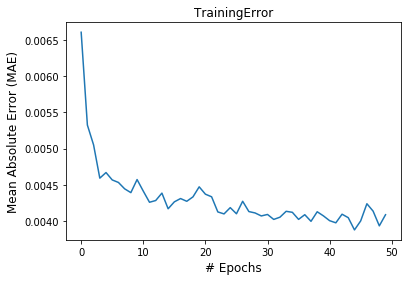

In [12]:
fig, ax1 = plt.subplots(1,1)
 
ax1.plot(yen_history.epoch, yen_history.history['loss'])
ax1.set_title('TrainingError')
 
if yen_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)

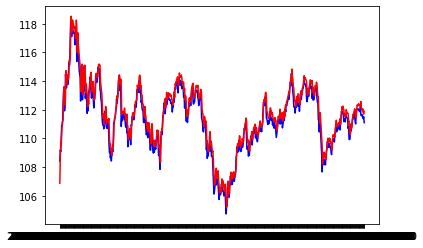

In [13]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(df[df['time']< split_data]['time'][window_len:],
         train['close'][window_len:], label='Actual', color='blue')
ax1.plot(df[df['time']< split_data]['time'][window_len:],
         ((np.transpose(yen_model.predict(train_lstm_in))+1) * train['close'].values[:-window_len])[0], 
         label='Predicted', color='red')

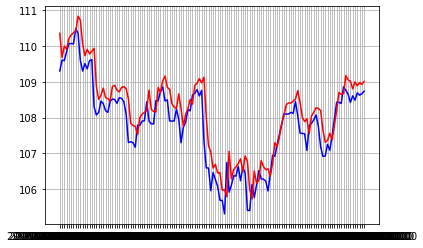

In [14]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(df[df['time']>= split_data]['time'][window_len:],
         test['close'][window_len:], label='Actual', color='blue')
ax1.plot(df[df['time']>= split_data]['time'][window_len:],
         ((np.transpose(yen_model.predict(test_lstm_in))+1) * test['close'].values[:-window_len])[0], 
         label='Predicted', color='red')
ax1.grid(True)